# CA684 Machine Learning Assignment Spring 2024

Dublin City University has teamed up with **Etsy** to create the 2024 CA684 Machine Learning assignment.

## Etsy.com

Etsy is the global marketplace for unique and creative goods. It’s home to a universe of special, extraordinary items, from unique handcrafted pieces to vintage treasures. Etsy operates two-sided online marketplaces that collectively connect nearly 100 million passionate and creative buyers and 7.7 million sellers around the world. 

Buyers come to the Etsy marketplace for meaningful, one-of-a-kind items handcrafted and curated with passion and expertise by our creative entrepreneurs. We are focused on attracting potential buyers to Etsy for everyday items that have meaning and those “special” purchase occasions that happen throughout the year. These include items that reflect an individual’s unique style; gifting that demonstrates thought and care; and celebrations that express creativity and fun.

On Etsy, someone searches for …
- Wall art every two seconds
- Wedding-related items every two seconds
- Gift-related items every second
- Antique or vintage items every half a second

## Challenge

Etsy has nearly 100 Million active listings on the etsy.com marketplace for sale from more than 5 million active sellers. You are provided a subset of those products as the training data. 

The task is to leverage the training dataset to learn patterns from and to predict the following attributes on an unseen test dataset given a products’ information:

- top category id
- bottom category id
- primary color id
- secondary color id

The goal is to maximize F1 for each of the classes on each attribute to predict (top category, bottom category, primary color and secondary color). Your approaches and models will be benchmarked against a hidden test dataset.

Bonus points will be given for submissions that:

- the trained model predicts the four attributes at the same time
- visualize some learned representations or embeddings and show that similar items cluster together
- compares the performance of pre-trained embeddings taken from hubs or papers with a fine-tuned model


## Getting Started

Here is some sample code to get you started on the challenge!

Happy Hacking!

In [14]:
# importing all the libraries needed for the project
import io
import os
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn import metrics
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pooja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# set random seed
np.random.seed(seed=42)

## Dataset

**Train Data** - The train and test datasets are shared in **parquet** format.

In order to download the dataset, please sign the NDA first.

In [16]:
#Store the path of data into the PATH Variable
PATH = f"./data/2024"

In [17]:
#Path contains the test and train files
!ls {PATH}

test
train


In [18]:
#Store the array of file and folder in the variable "parquet_filenames_train" for train data
parquet_filenames_train = !ls {PATH}/train

In [19]:
#Store the array of file and folder in the variable "parquet_filenames_test" for test data
parquet_filenames_test = !ls {PATH}/test

In [20]:
#Print 3 files using indexing
parquet_filenames_train[:3]

['part-00000-of-00362.parquet',
 'part-00001-of-00362.parquet',
 'part-00002-of-00362.parquet']

In [21]:
#The total numbers of files in train dataset, so we have total 362 files in train dataset 
f"Number of files in train: {len(parquet_filenames_train):,}"

'Number of files in train: 362'

In [22]:
#The total numbers of files in test dataset, so we have total 362 files in test dataset 
f"Number of files in test: {len(parquet_filenames_test):,}"

'Number of files in test: 362'

In [23]:
type(parquet_filenames_train)

IPython.utils.text.SList

In [24]:
type(parquet_filenames_test)

IPython.utils.text.SList

# Reading Dataset 

In [25]:
#The function which will read all the files and concat using pandas
def read_data(folder, filenames,max_files=10):
    """ Read parquet data from mutiple files """

    limited_filenames=filenames[:10]
    
    dataframes = [ 
        pd.read_parquet(f"{PATH}/{folder}/{filename}") 
        for filename in limited_filenames
    ]
    
    return pd.concat(dataframes)

In [26]:
#reading training data using read_data
df_train = read_data("train", parquet_filenames_train)

In [27]:
#reading training data using read_data
df_test = read_data("test", parquet_filenames_train)

# Data Cleaning and EDA

In [28]:
#shape of train 
df_train.shape

(6180, 26)

In [29]:
#total of the rows in the training dataset - total rows in the training data is - 229624
f"Number of rows in train: {len(df_train):}"

'Number of rows in train: 6180'

In [30]:
#total of the columns in the training dataset - total columns in the training data is - 26
f"Number of columns in train: {len(df_train.columns):}"

'Number of columns in train: 26'

In [31]:
#Total unique products in the train data
f"Number of unique products in train: {len(df_train['product_id'].unique()):,}"

'Number of unique products in train: 6,180'

In [32]:
#info of train dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6180 entries, 0 to 91
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   product_id            6180 non-null   int64 
 1   title                 6180 non-null   object
 2   description           6180 non-null   object
 3   tags                  6180 non-null   object
 4   type                  6180 non-null   object
 5   room                  6180 non-null   object
 6   craft_type            6180 non-null   object
 7   recipient             6180 non-null   object
 8   material              6180 non-null   object
 9   occasion              6180 non-null   object
 10  holiday               6180 non-null   object
 11  art_subject           6180 non-null   object
 12  style                 6180 non-null   object
 13  shape                 6180 non-null   object
 14  pattern               6180 non-null   object
 15  bottom_category_id    6180 non-null   in

In [33]:
#info of train dataset
df_train.describe()

,product_id,bottom_category_id,top_category_id,primary_color_id,secondary_color_id,image/width,image/height
count,6.180000e+03,6180.000000,6180.000000,6180.000000,6180.000000,6180.000000,6180.000000
mean,1.204368e+09,4014.949029,6.986731,8.669417,9.499029,566.495146,573.531553
std,3.646848e+08,4243.271322,3.179145,6.500534,6.325464,25.859471,158.899210
min,1.382439e+07,83.000000,0.000000,0.000000,0.000000,176.000000,143.000000
25%,9.486595e+08,883.000000,5.000000,2.000000,4.000000,570.000000,428.000000
50%,1.281058e+09,1964.000000,8.000000,9.000000,10.000000,570.000000,570.000000
75%,1.524846e+09,6504.000000,8.000000,16.000000,16.000000,570.000000,712.000000
max,1.669765e+09,12459.000000,14.000000,19.000000,19.000000,570.000000,1420.000000


In [34]:
#printing all the columns from the columns
list(df_train.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern',
 'bottom_category_id',
 'bottom_category_text',
 'top_category_id',
 'top_category_text',
 'primary_color_id',
 'primary_color_text',
 'secondary_color_id',
 'secondary_color_text',
 'image/encoded',
 'image/width',
 'image/height']

In [35]:
#printing the 0 index record with its column and values
df_train.iloc[0]

product_id                                                      699437355
title                   Children&#39;s circle skirt BLUE GALAXY made o...
description             The fuxandfriends children&#39;s full circle s...
tags                                                                     
type                                                             physical
room                                                                     
craft_type                                                               
recipient                                                                
material                                                                 
occasion                                                                 
holiday                                                                  
art_subject                                                              
style                                                                    
shape                                 

In [36]:
#head - printing first 5 records from training dataset
df_train.head()

,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,...,bottom_category_text,top_category_id,top_category_text,primary_color_id,primary_color_text,secondary_color_id,secondary_color_text,image/encoded,image/width,image/height
0,699437355,Children&#39;s circle skirt BLUE GALAXY made o...,The fuxandfriends children&#39;s full circle s...,,physical,,,,,,...,clothing.girls_clothing.skirts,5,clothing,2,blue,2,blue,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,426
1,1323699538,"Cow Birthday Tutu for kids, Farm Theme Bday Ou...",💄This listing is for the TUTU ONLY (double rib...,"birthday outfit,girls birthday shirt,Tutu outf...",physical,,,,,birthday,...,clothing.girls_clothing.skirts,5,clothing,11,pink,1,black,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,475
2,1142910558,"Zebra print tutu, animal print Skirt, World bo...",All tutus are handmade to order with two layer...,"black and white tutu,striped skirt,zebra tutu,...",physical,,,,,,...,clothing.girls_clothing.skirts,5,clothing,17,white,1,black,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,396
3,1320296928,"Lilac Tutu Rainbow Dots // Girl&#39;s Tutu, Tu...",Step aside because the princess pop star is he...,"tutu,girls skirt,sparkling tutu,fun skirt,ball...",physical,,,,,birthday,...,clothing.girls_clothing.skirts,5,clothing,12,purple,13,rainbow,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,570
4,854901795,Bumblebee tutu yellow and black tutu halloween...,"Sparkle, shimmer, twirl and spin,\nThis tutu&#...","dog tutu,fluffy tutu,dance tutu,skirt,flower g...",physical,,,,,birthday,...,clothing.girls_clothing.skirts,5,clothing,18,yellow,1,black,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,570


#### Unique values and their count of values 

In [37]:
#Unique values in the type columns
df_train['type'].unique()

array(['physical', 'download', ''], dtype=object)

In [38]:
#Number of unique values in type column
df_train['type'].value_counts(dropna=False)

physical    6076
download      97
               7
Name: type, dtype: int64

In [39]:
#Unique values in the top_category_text columns
df_train['top_category_text'].unique()

array(['clothing', 'home_and_living', 'bath_and_beauty',
       'bags_and_purses', 'craft_supplies_and_tools',
       'books_movies_and_music', 'weddings', 'accessories',
       'pet_supplies', 'toys_and_games', 'jewelry', 'shoes',
       'electronics_and_accessories', 'paper_and_party_supplies',
       'art_and_collectibles'], dtype=object)

In [40]:
#Number of unique values in top_category_text column
df_train['top_category_text'].value_counts(dropna=False,sort=True, ascending=False)

home_and_living                1980
clothing                        984
craft_supplies_and_tools        747
bags_and_purses                 447
jewelry                         357
weddings                        271
bath_and_beauty                 268
toys_and_games                  261
books_movies_and_music          184
shoes                           177
electronics_and_accessories     135
accessories                      93
paper_and_party_supplies         93
pet_supplies                     92
art_and_collectibles             91
Name: top_category_text, dtype: int64

In [41]:
#Unique values in the bottom_category_text columns
df_train['bottom_category_text'].unique()

array(['clothing.girls_clothing.skirts',
       'clothing.gender_neutral_adult_clothing.sweaters',
       'home_and_living.home_improvement.lighting_parts.light_bulbs',
       'home_and_living.food_and_drink.snacks',
       'clothing.gender_neutral_kids_clothing.leggings',
       'bath_and_beauty.personal_care.face_mask_accessories.mask_lanyards_and_chains',
       'bags_and_purses.handbags.clutches_and_evening_bags',
       'craft_supplies_and_tools.knives_and_cutting_tools.knives',
       'books_movies_and_music.books.childrens_books',
       'home_and_living.lighting.light_fixtures.ceiling_lights.pendant_lights',
       'weddings.decorations.aisle_runners_and_decor',
       'home_and_living.bedding.duvet_covers',
       'home_and_living.spirituality_and_religion.natural_curios.mineral',
       'books_movies_and_music.books.art_and_photography_books',
       'home_and_living.kitchen_and_dining.dining_and_serving.serving_odds_and_ends.sugar_bowls_and_creamers',
       'accessories.bou

In [42]:
#Number of unique values in top_category_text column
df_train['bottom_category_text'].value_counts(dropna=False,sort=True, ascending=False)

home_and_living.food_and_drink.snacks                                           96
clothing.womens_clothing.tops_and_tees.crop_and_tube_tops                       95
craft_supplies_and_tools.paints_inks_and_dyes.paint.chalk_paint                 95
craft_supplies_and_tools.pens_pencils_and_marking_tools.nibs_and_nib_holders    95
home_and_living.outdoor_and_garden.fire_pits.fire_pits                          95
                                                                                ..
jewelry.brooches_pins_and_clips.brooches                                        85
craft_supplies_and_tools.raw_materials.clay_and_ceramic.ceramic                 82
craft_supplies_and_tools.canvas_and_surfaces.printing_plates                    65
craft_supplies_and_tools.frames_hoops_and_stands                                58
electronics_and_accessories.parts_and_electrical.sockets_and_wiring             46
Name: bottom_category_text, Length: 70, dtype: int64

In [43]:
#Unique values in the primary_color_text columns
df_train['primary_color_text'].unique()

array(['blue', 'pink', 'white', 'purple', 'yellow', 'red', 'black',
       'rainbow', 'beige', 'green', 'orange', 'other', 'gold', 'brown',
       'bronze', 'clear', 'silver', 'copper', 'rose gold'], dtype=object)

In [44]:
df_train['primary_color_text'].value_counts(dropna=False,sort=True, ascending=False)

blue         803
black        780
white        772
brown        568
green        403
red          391
pink         379
beige        336
silver       297
other        294
gold         269
yellow       213
purple       178
orange       166
rainbow      121
clear        102
bronze        55
copper        41
rose gold     12
Name: primary_color_text, dtype: int64

In [45]:
#Unique values in the secondary_color_text columns
df_train['secondary_color_text'].unique()

array(['blue', 'black', 'rainbow', 'green', 'white', 'gold', 'orange',
       'pink', 'silver', 'other', 'purple', 'yellow', 'rose gold',
       'beige', 'red', 'brown', 'clear', 'bronze', 'copper'], dtype=object)

In [46]:
#Number of unique values in secondary_color_text column
df_train['secondary_color_text'].value_counts(dropna=False,sort=True, ascending=False)

white        879
black        723
brown        533
blue         455
green        438
gold         430
red          398
silver       368
pink         362
other        266
beige        265
yellow       251
rainbow      223
purple       168
orange       153
clear        116
bronze        65
copper        55
rose gold     32
Name: secondary_color_text, dtype: int64

In [47]:
#Total number of unique column in - bottom category
f"Number of top categories in train: {len(df_train['top_category_text'].unique()):,}"

'Number of top categories in train: 15'

In [48]:
#Total number of unique column in - top category
f"Number of bottom categories in train: {len(df_train['bottom_category_text'].unique()):,}"

'Number of bottom categories in train: 70'

In [49]:
#Total number of unique column in - primary color text
f"Number of primary colors in train: {len(df_train['primary_color_text'].unique()):,}"

'Number of primary colors in train: 19'

In [50]:
#Total number of unique column in - secondary color text
f"Number of secpndary colors in train: {len(df_train['secondary_color_text'].unique()):,}"

'Number of secpndary colors in train: 19'

#### checking duplicates 

In [51]:
#checking duplicate values - we don't have duplicate values/data
df_train.duplicated().sum()

0

In [52]:
#checking duplicate values - duplicate columns - we don't have duplicate columns

def find_duplicate_columns(df):
    duplicate_columns = {}
    columns_checked = []
    for i in range(df.shape[1]):
        column_i = df.iloc[:, i]
        for j in range(i + 1, df.shape[1]):
            column_j = df.iloc[:, j]
            if column_i.equals(column_j):
                col_name_i = df.columns[i]
                col_name_j = df.columns[j]
                if col_name_i not in columns_checked:
                    duplicate_columns[col_name_i] = [col_name_j]
                else:
                    duplicate_columns[col_name_i].append(col_name_j)
        columns_checked.append(df.columns[i])
    return duplicate_columns

print(find_duplicate_columns(df_train))

{}


#### Checking missing values

In [53]:
#Checking the missing value in the data 
missing_values_df_train= df_train.isnull().sum() 
missing_values_df_train

product_id              0
title                   0
description             0
tags                    0
type                    0
room                    0
craft_type              0
recipient               0
material                0
occasion                0
holiday                 0
art_subject             0
style                   0
shape                   0
pattern                 0
bottom_category_id      0
bottom_category_text    0
top_category_id         0
top_category_text       0
primary_color_id        0
primary_color_text      0
secondary_color_id      0
secondary_color_text    0
image/encoded           0
image/width             0
image/height            0
dtype: int64

In [54]:
import html 
# Assuming you already have 'my_df' DataFrame 
# Convert HTML encoded characters to their corresponding symbols
df_train['title'] = df_train['title'].apply(html.unescape) 
df_train['description'] = df_train['description'].apply(html.unescape) 
df_train['tags'] = df_train['tags'].apply(html.unescape) # Print the first few rows to check if the decoding worked print(my_df.head())

In [55]:
 #Function to remove any special or extra symbol with stop words
remove_special_character = re.compile('[/(){}\[\]\|@,;]')
remove_extra_symbol = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = remove_special_character.sub(' ', text)
    text = remove_extra_symbol.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [56]:
#count of description column before cleaning in train dataset
print(df_train[df_train['description'].notnull()]['description'].apply(lambda x: len(x.split(' '))).sum())

1086870


In [57]:
#count of description column after cleaning in train dataset
df_train['description'] = df_train['description'].apply(lambda x: clean_text(x) if pd.notnull(x) else None)
print(df_train[df_train['description'].notnull()]['description'].apply(lambda x: len(x.split(' '))).sum())

675493


In [58]:
#count of title column before cleaning in train dataset
print(df_train[df_train['title'].notnull()]['title'].apply(lambda x: len(x.split(' '))).sum())

88697


In [59]:
#count of` title column after cleaning in train dataset
df_train['title'] = df_train['title'].apply(lambda x: clean_text(x) if pd.notnull(x) else None)
print(df_train[df_train['title'].notnull()]['title'].apply(lambda x: len(x.split(' '))).sum())

78598


In [60]:
#count of tags column before cleaning in train dataset
print(df_train[df_train['tags'].notnull()]['tags'].apply(lambda x: len(x.split(' '))).sum())

73404


In [61]:
#count of tags column after cleaning in train dataset
df_train['tags'] = df_train['tags'].apply(lambda x: clean_text(x) if pd.notnull(x) else None)
print(df_train[df_train['tags'].notnull()]['tags'].apply(lambda x: len(x.split(' '))).sum())

124977


### Visualizations

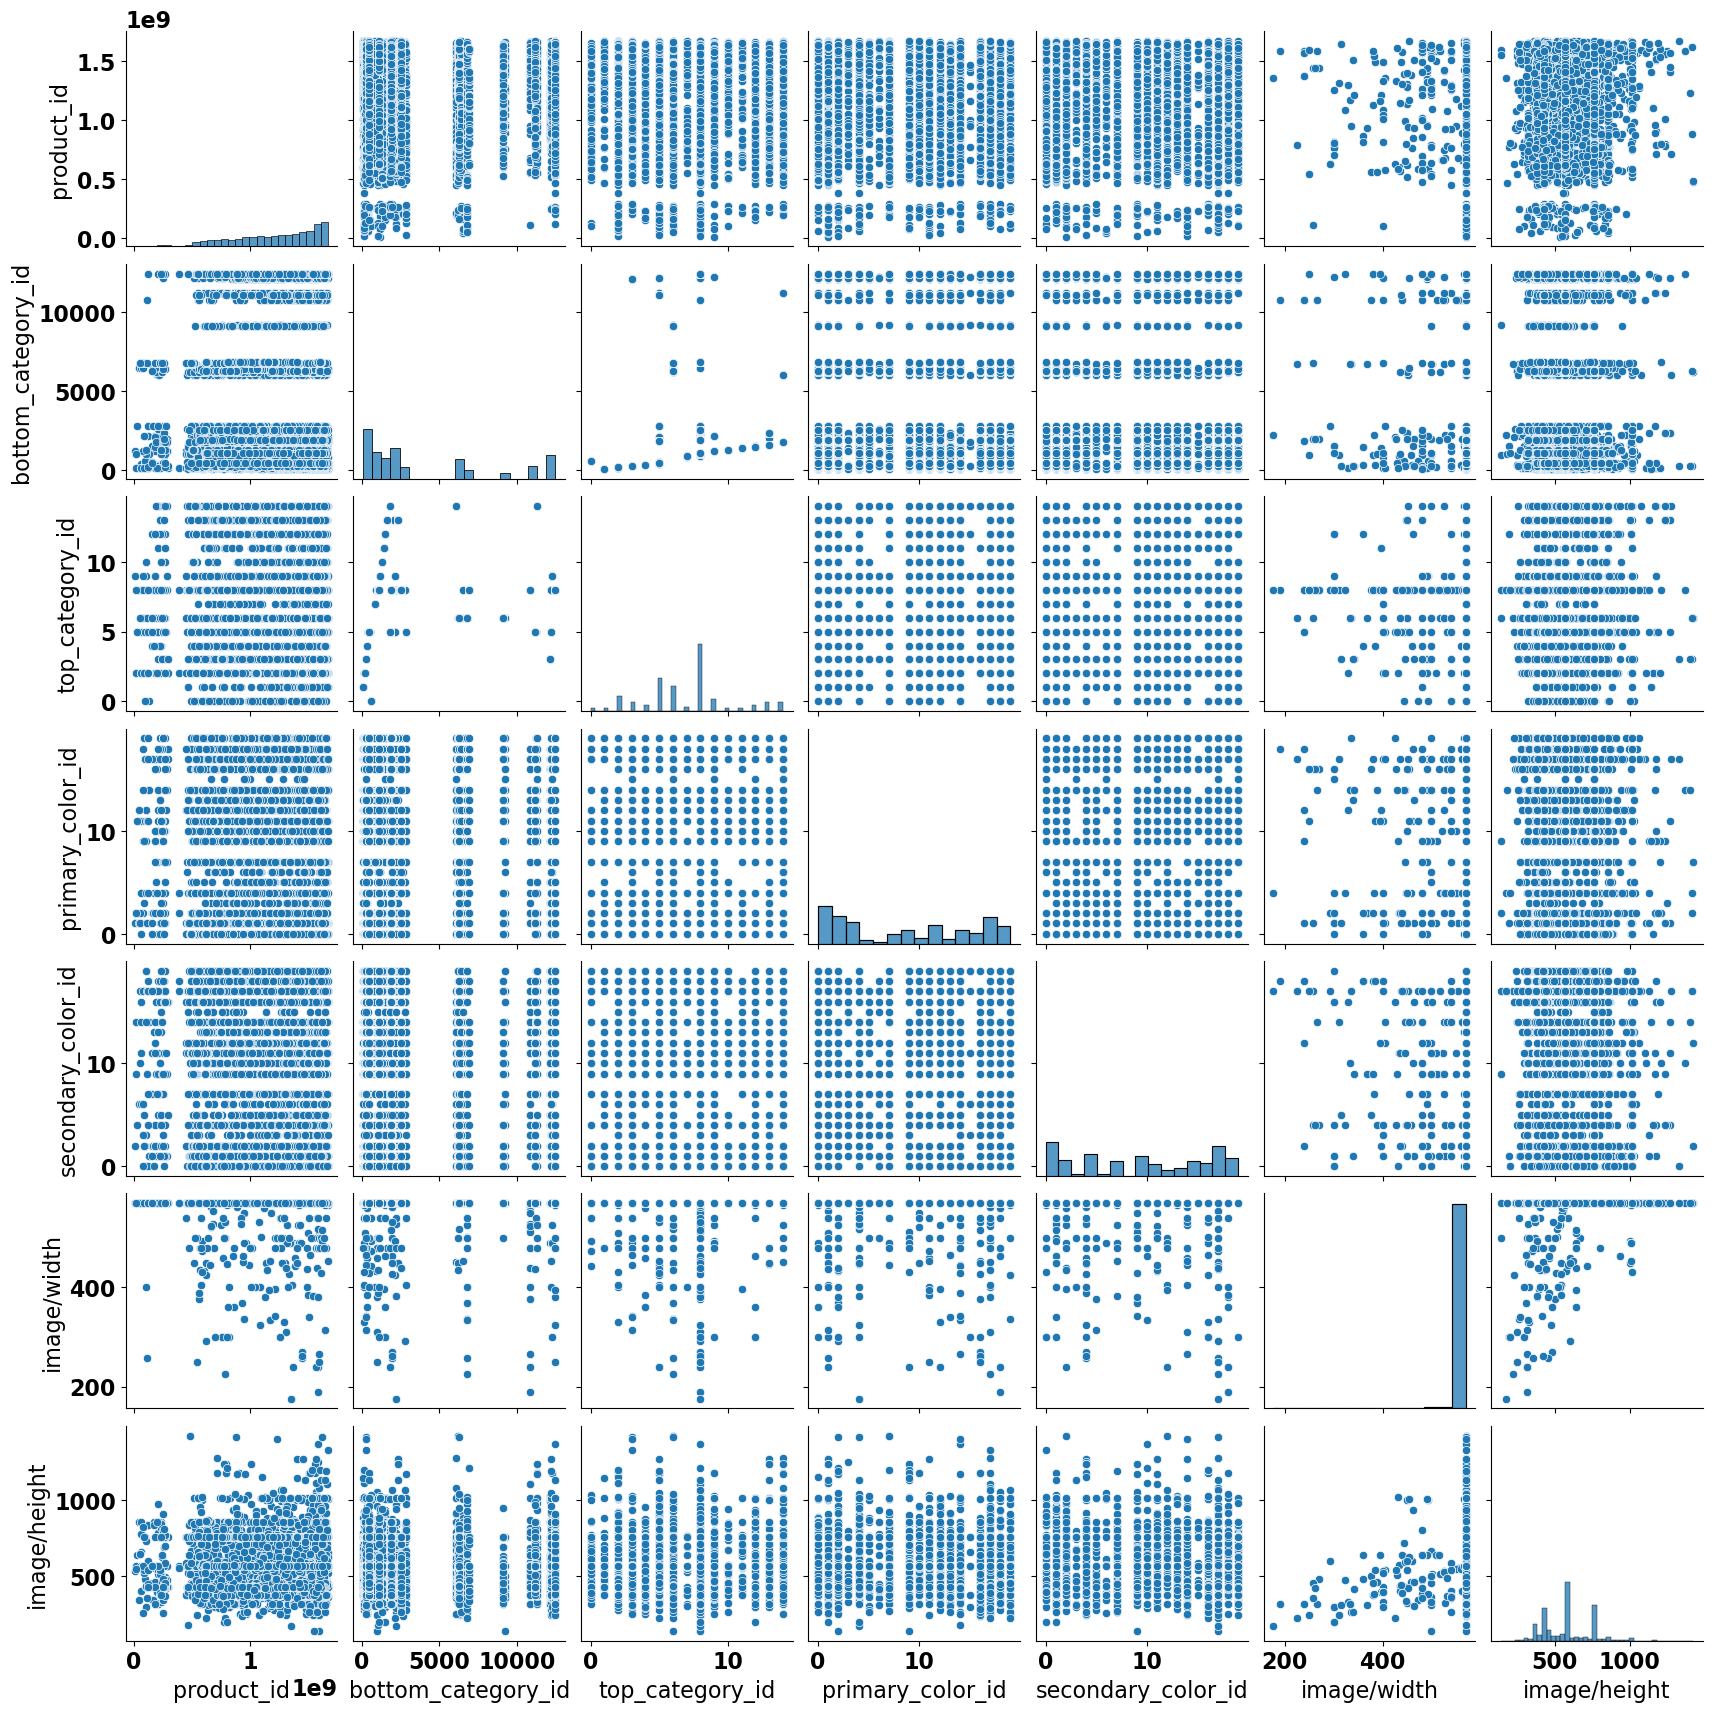

In [62]:
import seaborn as sns
sns.pairplot(df_train)

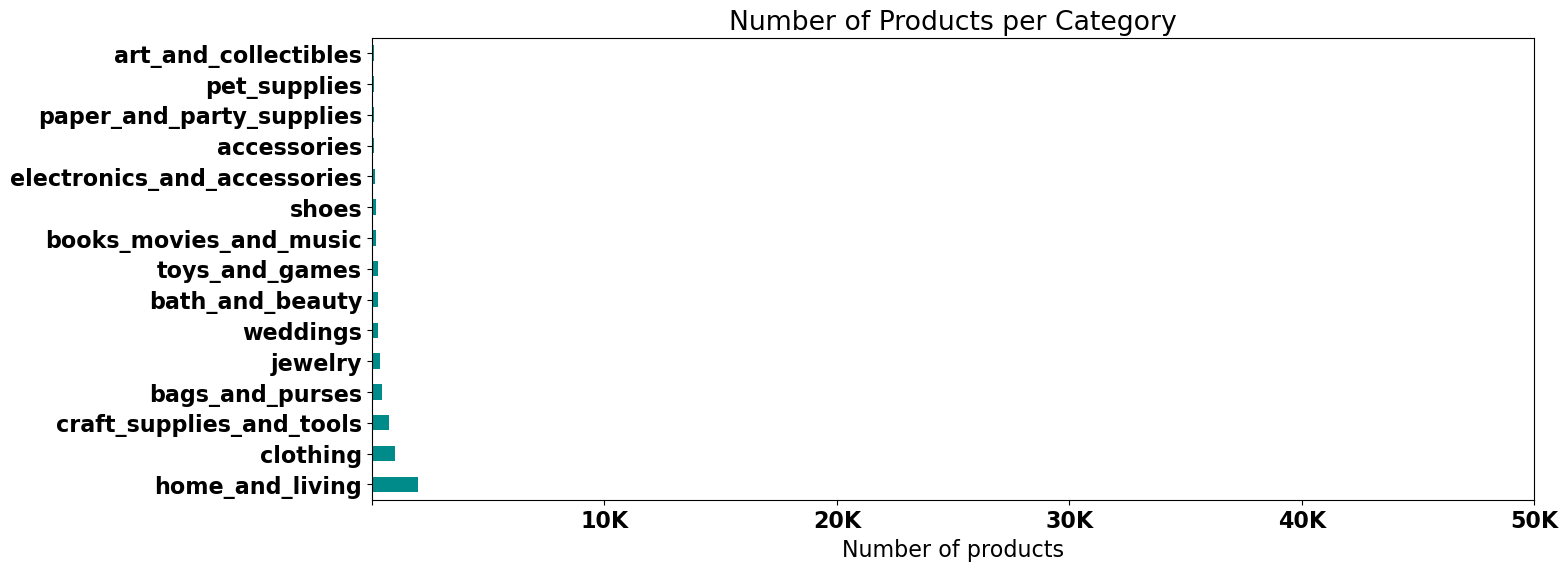

In [63]:
#Visualize the number of products per category in the 'top_category_text' column of the DataFrame `df_train`, with specified plot settings such as figure size, x-axis limits, step size, color, and labeling.

figsize = (15, 6)
column = 'top_category_text'
x_limit = 60000
x_step = 10000
color = 'darkcyan'
    
figure, ax = plt.subplots(figsize=figsize)
pd.value_counts(
    df_train[column], 
    sort=True, ascending=False).plot.barh(color=color)
plt.title(f"Number of Products per Category")
xlabels = [f'{x // 1000:,}K' for x in range(0, x_limit, x_step)]
plt.xticks(range(0, x_limit, x_step), xlabels)
plt.xlabel('Number of products')
plt.setp(ax.get_xticklabels()[0], visible=False)
plt.show()

In [64]:
def show_images(dataframe, N=100):
    
    num_cols = 5
    num_rows = N // num_cols
    plt_height = 3 * num_rows
    
    plt.figure(figsize=(12, plt_height))
    for i, row in dataframe[:N].iterrows():
        # axis
        ax = plt.subplot(num_rows, num_cols, i + 1)
        # data
        img_bytes = row["image/encoded"]
        label = row["top_category_text"] if "top_category_text" in row else "unknown"
        # image
        bytes_io = io.BytesIO(img_bytes)
        image = Image.open(bytes_io)
        # plot
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image)
        plt.xlabel(label, fontsize = 12)
    plt.show()

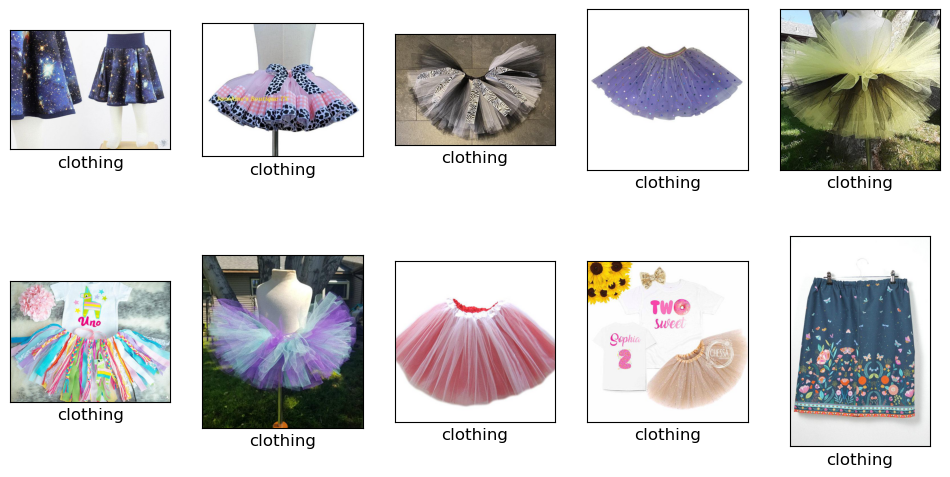

In [65]:
show_images(df_train, 10)

### Test Dataset

The test dataset will be used to predict using the model/s you have trained



In [66]:
#Reading the test data in the variable df_test
df_test = read_data("test", parquet_filenames_test)

In [67]:
#Number of rows in the test data
f'Number of rows in test: {len(df_test):,}'

'Number of rows in test: 583'

In [68]:
# number of unique products 
f"Number of unique products in test: {len(df_test['product_id'].unique()):,}"

'Number of unique products in test: 583'

In [69]:
#Total number of columns in test
f"Number of columns in test: {len(df_test.columns):,}"

'Number of columns in test: 18'

In [70]:
#total number of columns 
list(df_test.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern',
 'image/encoded',
 'image/width',
 'image/height']

In [71]:
#printing the '0' record
df_test.iloc[0]

product_id                                               661373440
title            Classroom Valentine Favors, Valentine Pencils,...
description      Valentine Favors, Robots of Love Vinyl Pencil ...
tags             Valentines day favor,kindergarten treats,valen...
type                                                      physical
room                                                              
craft_type                                            kids' crafts
recipient                                                         
material                                                          
occasion                                                          
holiday                                            valentine's day
art_subject                                                       
style                                                             
shape                                                             
pattern                                                       

In [72]:
#printing the head
df_test.head()

,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,holiday,art_subject,style,shape,pattern,image/encoded,image/width,image/height
0,661373440,"Classroom Valentine Favors, Valentine Pencils,...","Valentine Favors, Robots of Love Vinyl Pencil ...","Valentines day favor,kindergarten treats,valen...",physical,,kids' crafts,,,,valentine's day,,,,,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,739
1,1501009290,5 Colour Slatepencils In One Pack Order NOw,5 Colour Slatepencils In One Pack Order NOw\n\...,"slatepencils,clay,nakumatt,edibleclay",physical,,drawing & drafting,,,,,,,,,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,321
2,1105447030,"No 2 Pencils by Associated Commercial, #2 Wri...","This listing is for a dozen, unused pre sharpe...","Faber Castell,aw faber,Faber-Castell,antique p...",physical,,drawing & drafting,,,,,,,,,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,330
3,1140081090,"Personalized Carpenter Pencils, Engraved Carpe...",EtchThisOut is now offering Carpenter Pencils ...,"Personalized Pencils,Carpenter Pencils,Carpent...",physical,,drawing & drafting,,,birthday,valentine's day,,,,,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,570
4,793448890,Vintage 1960&#39;s Autopoint mechanical pencil...,Vintage 1950&#39;s Autopoint mechanical pencil...,"Mechanical pencil,Autopoint pencil,Drafting pe...",physical,,calligraphy,,,,,,,,,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,570


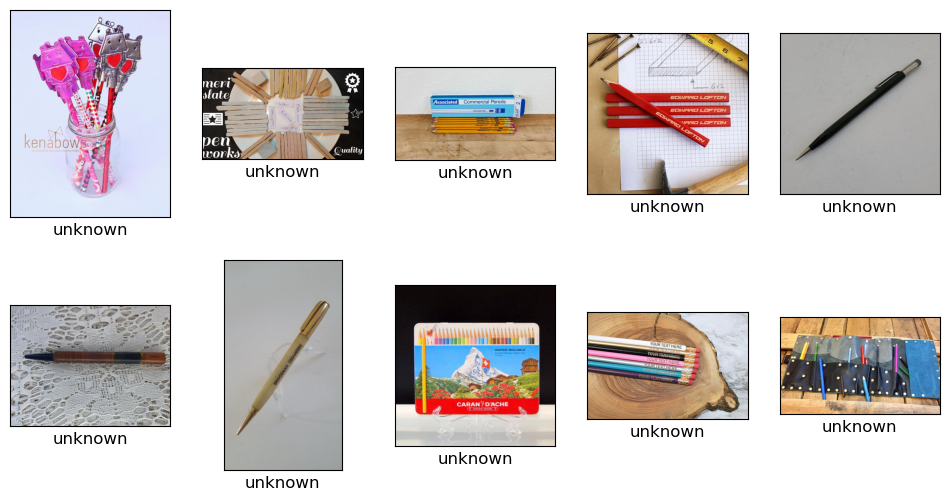

In [73]:
#printing the images from the test data , 10 data
show_images(df_test, 10)

## Model Training

Let's first split the data to be able to evaluate our model against a validation dataset. This validation set can also be used to fine tune your model before making the predictions on the hidden test set.

In [74]:
# spiliting the dataset into df_training and df_validation
from sklearn.model_selection import train_test_split

df_training, df_validation = train_test_split(
    df_train, 
    test_size=0.2,  
    random_state=42)



In [75]:
#Number of products for training
f"Number of products for training: {len(df_training):,}"

'Number of products for training: 4,944'

In [76]:
#Number of products for validation
f"Number of products for validation: {len(df_validation):,}"

'Number of products for validation: 1,236'

In [77]:
#values count in df_training
df_training['bottom_category_text'].value_counts()

paper_and_party_supplies.paper.stationery.notepads                       82
home_and_living.home_decor.wall_decor                                    80
home_and_living.lighting.light_fixtures.ceiling_lights.pendant_lights    79
weddings.decorations.aisle_runners_and_decor                             79
clothing.womens_clothing.tops_and_tees.crop_and_tube_tops                78
                                                                         ..
books_movies_and_music.books.art_and_photography_books                   64
craft_supplies_and_tools.raw_materials.clay_and_ceramic.ceramic          61
craft_supplies_and_tools.canvas_and_surfaces.printing_plates             56
craft_supplies_and_tools.frames_hoops_and_stands                         50
electronics_and_accessories.parts_and_electrical.sockets_and_wiring      37
Name: bottom_category_text, Length: 70, dtype: int64

In [78]:
#values count in df_validations
df_validation['bottom_category_text'].value_counts()

books_movies_and_music.books.art_and_photography_books                   27
craft_supplies_and_tools.brushes.paint_brushes                           27
home_and_living.bedding.duvet_covers                                     24
bags_and_purses.handbags.clutches_and_evening_bags                       24
home_and_living.food_and_drink.snacks                                    23
                                                                         ..
home_and_living.lighting.light_fixtures.ceiling_lights.pendant_lights    11
weddings.decorations.aisle_runners_and_decor                             10
craft_supplies_and_tools.canvas_and_surfaces.printing_plates              9
electronics_and_accessories.parts_and_electrical.sockets_and_wiring       9
craft_supplies_and_tools.frames_hoops_and_stands                          8
Name: bottom_category_text, Length: 70, dtype: int64

In [79]:
#Values_count in top_category_text
df_training['top_category_text'].value_counts()

home_and_living                1595
clothing                        782
craft_supplies_and_tools        596
bags_and_purses                 354
jewelry                         278
weddings                        225
toys_and_games                  214
bath_and_beauty                 209
books_movies_and_music          137
shoes                           137
electronics_and_accessories     112
paper_and_party_supplies         82
pet_supplies                     77
art_and_collectibles             74
accessories                      72
Name: top_category_text, dtype: int64

In [80]:
df_validation['top_category_text'].value_counts()

home_and_living                385
clothing                       202
craft_supplies_and_tools       151
bags_and_purses                 93
jewelry                         79
bath_and_beauty                 59
toys_and_games                  47
books_movies_and_music          47
weddings                        46
shoes                           40
electronics_and_accessories     23
accessories                     21
art_and_collectibles            17
pet_supplies                    15
paper_and_party_supplies        11
Name: top_category_text, dtype: int64

### Model Training

- processes the text using `CountVectorizer`, that builds a dictionary of features and transforms documents to feature vectors
- extracts term frequencies and inverse document frequencies using `TfidfTransformer`, (see [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))
- trains a naïve Bayes classifier, which gives us a nice baseline

# Naive Bayes

In [82]:
#First we will use Naive Bayes 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Use Multinomial Naive Bayes classifier
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

### Naive Bayes for - Top category text

In [349]:
train_text = df_training['title'].fillna('').values

In [350]:
train_labels = df_training['top_category_text'].values

In [351]:
text_clf.fit(train_text, train_labels)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression())])

### Evaluation

Using our validation dataset, compute a number of metrics to measure how well we generalize on our validation set.

In [87]:
val_text = df_validation['title'].fillna('').values

val_labels = df_validation['top_category_text'].values

In [88]:
index = 0
print(f"""
Product's title: {val_text[index][:80]}...
Prediction: '{text_clf.predict([val_text[index]])[0]}', Groundtruth: '{val_labels[index]}'
""".strip())

Product's title: get vote shoes handpainted custom canvas slipons...
Prediction: 'home_and_living', Groundtruth: 'shoes'


In [89]:
predictions = text_clf.predict(val_text)

In [90]:
f1 = metrics.f1_score(val_labels, predictions, average='weighted')

In [91]:
f"F1 score: {f1:.4f}"

'F1 score: 0.7103'

In [92]:
print(metrics.classification_report(val_labels, predictions))

                             precision    recall  f1-score   support

                accessories       1.00      0.05      0.09        21
       art_and_collectibles       0.00      0.00      0.00        17
            bags_and_purses       0.95      0.65      0.77        93
            bath_and_beauty       0.92      0.41      0.56        59
     books_movies_and_music       1.00      0.09      0.16        47
                   clothing       0.88      0.98      0.93       202
   craft_supplies_and_tools       0.97      0.78      0.86       151
electronics_and_accessories       1.00      0.35      0.52        23
            home_and_living       0.57      0.99      0.73       385
                    jewelry       1.00      0.62      0.77        79
   paper_and_party_supplies       1.00      0.09      0.17        11
               pet_supplies       1.00      0.40      0.57        15
                      shoes       1.00      0.40      0.57        40
             toys_and_games      

C:\Users\Pooja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Pooja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Pooja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [93]:
metrics.confusion_matrix(val_labels, predictions)

array([[  1,   0,   0,   0,   0,   6,   0,   0,  14,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  17,   0,   0,   0,   0,
          0,   0],
       [  0,   0,  60,   0,   0,   3,   1,   0,  29,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   1,  24,   0,   4,   0,   0,  30,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   4,   3,   1,   0,  39,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 198,   0,   0,   4,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   1, 118,   0,  32,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   8,  15,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   1,   0,   0,   1,   0,   0, 383,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  30,  49,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   1,   0,   0,   9,   0,   1,   0,   0,
       

### Navie bayes - bottom category

In [94]:
train_labels = df_training['bottom_category_text'].values
text_clf.fit(train_text, train_labels)
val_text = df_validation['title'].fillna('').values
val_labels = df_validation['bottom_category_text'].values
predictions = text_clf.predict(val_text)
f1 = metrics.f1_score(val_labels, predictions, average='weighted')

In [95]:
f"F1 score: {f1:.4f}"

'F1 score: 0.8483'

In [96]:
#print(metrics.classification_report(val_labels, predictions))

### Navie bayes - primary category

In [97]:
train_labels = df_training['primary_color_text'].values
text_clf.fit(train_text, train_labels)
val_text = df_validation['title'].fillna('').values
val_labels = df_validation['primary_color_text'].values
predictions = text_clf.predict(val_text)
f1 = metrics.f1_score(val_labels, predictions, average='weighted')

In [98]:
f"F1 score: {f1:.4f}"

'F1 score: 0.2122'

### Navie bayes -secondary category

In [99]:
train_labels = df_training['secondary_color_text'].values
text_clf.fit(train_text, train_labels)
val_text = df_validation['title'].fillna('').values
val_labels = df_validation['secondary_color_text'].values
predictions = text_clf.predict(val_text)
f1 = metrics.f1_score(val_labels, predictions, average='weighted')

In [100]:
f"F1 score: {f1:.4f}"

'F1 score: 0.1570'

## Random Forest

## Random Forest - Bottom category 

In [172]:
from nltk.corpus import stopwords
import nltk
import re
import string, collections
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = EnglishStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower() #make text lowercase and fill na
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub('\\n', '',str(text))
    text = re.sub("\[\[User.*",'',str(text))
    text = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(text))
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text) #remove hyperlinks
    text = re.sub(r'\:(.*?)\:', '', text) #remove emoticones
    text = re.sub(r'[\w\.-]+@[\w\.-]+', '', str(text)) #remove email
    text = re.sub(r'(?<=@)\w+', '', text) #remove @
    text = re.sub(r'[0-9]+', '', text) #remove numbers
    text = re.sub("[^A-Za-z0-9 ]", '', text) #remove non alphanumeric like ['@', '#', '.', '(', ')']
    text = re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', '', text) #remove punctuations from sentences
    text = re.sub('<.*?>+', '', str(text))
    text = re.sub('[%s]' % re.escape(string.punctuation), '', str(text))
    text = re.sub('\w*\d\w*', '', str(text))
    text = tokenizer.tokenize(text)
    text = [word for word in text if not word in stop_words]
    #text = [lemmatizer.lemmatize(word) for word in text]
    text = [stemmer.stem(word) for word in text]
    final_text = ' '.join( [w for w in text if len(w)>1] ) #remove word with one letter
    return final_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pooja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [177]:
df_train['description']=df_train['description'].fillna('')
df_test['description']=df_test['description'].fillna('')
from sklearn.model_selection import train_test_split

df_training, df_validation = train_test_split(
    df_train, 
    test_size=0.2, 
    stratify=df_train['bottom_category_text'], 
    random_state=42)
df_training['description']=df_training['description'].fillna('')
df_validation['description']=df_validation['description'].fillna('')
df_training['title']=df_training['title'].fillna('')
df_validation['title']=df_validation['title'].fillna('')
df_training['description'] = df_training['description'].apply(lambda x : clean_text(x))
df_training['title'] = df_training['title'].apply(lambda x : clean_text(x))
df_validation['description'] = df_validation['description'].apply(lambda x : clean_text(x))
df_validation['title'] = df_validation['title'].apply(lambda x : clean_text(x))

In [178]:
f"Number of products for training: {len(df_training):,}"

'Number of products for training: 4,944'

In [179]:
f"Number of products for validation: {len(df_validation):,}"

'Number of products for validation: 1,236'

In [184]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(verbose=100,n_jobs=-1,max_depth=200)), #n_jobs = -1 means use all cores, verbose is for logging , max_Depth to use lower depths so that we dont overfit the model
])
train_text = df_training['description'] + df_training['title'] + df_training['tags']
train_text = train_text.fillna('').values
train_labels = df_training['bottom_category_text'].values
X = train_text
Y = train_labels

text_clf = text_clf.fit(X, Y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s

building tree 18 of 100
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
building tree 19 of 100[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s

building tree 20 of 100
[Parallel(n_j

In [186]:
val_text = df_validation['description'] + df_validation['title'] + df_validation['tags']
val_text = val_text.fillna('').values
val_labels = df_validation['bottom_category_text'].values
predictions = text_clf.predict(val_text)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  15 tasks      | elaps

In [187]:
print(classification_report(val_labels,predictions))


                                                                                                      precision    recall  f1-score   support

                                                          accessories.bouquets_and_corsages.corsages       1.00      0.95      0.97        19
                                                       art_and_collectibles.fiber_arts.woven_baskets       0.94      0.94      0.94        18
                                                                                     bags_and_purses       0.64      0.53      0.58        17
                                    bags_and_purses.food_and_insulated_bags.drink_holders_and_cozies       0.77      1.00      0.87        17
                                                  bags_and_purses.handbags.clutches_and_evening_bags       0.81      0.94      0.87        18
                                                            bags_and_purses.handbags.top_handle_bags       0.73      0.61      0.67        18
     

In [188]:
f1 = metrics.f1_score(val_labels, predictions, average='weighted')

In [189]:
f"F1 score: {f1:.4f}" 

'F1 score: 0.9040'

In [190]:
metrics.confusion_matrix(val_labels, predictions)

array([[18,  0,  0, ...,  0,  0,  0],
       [ 0, 17,  0, ...,  0,  0,  0],
       [ 0,  0,  9, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 18,  0,  0],
       [ 0,  0,  0, ...,  0, 17,  0],
       [ 0,  0,  0, ...,  0,  0, 13]], dtype=int64)

In [192]:
df_test['description']=df_test['description'].fillna('')
df_test['title']=df_test['title'].fillna('')
df_test['description'] = df_test['description'].apply(lambda x : clean_text(x))
df_test['title'] = df_test['title'].apply(lambda x : clean_text(x))

In [193]:
test_text = df_test['description'] + df_test['title'] + df_test['tags']
test_text = test_text.fillna('').values

In [194]:
predictions_test = text_clf.predict(test_text)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  15 tasks      | elaps

In [198]:
map1 = set(df_train[['bottom_category_id','bottom_category_text']].to_records(index=False).tolist())
mapping = {y:x for (x,y) in map1}

In [199]:
test_predictions_mapped = [mapping[x] for x in predictions_test]

## Random Forest - Bottom category

In [200]:
from nltk.corpus import stopwords
import nltk
import re
import string, collections
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = EnglishStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower() #make text lowercase and fill na
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub('\\n', '',str(text))
    text = re.sub("\[\[User.*",'',str(text))
    text = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(text))
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text) #remove hyperlinks
    text = re.sub(r'\:(.*?)\:', '', text) #remove emoticones
    text = re.sub(r'[\w\.-]+@[\w\.-]+', '', str(text)) #remove email
    text = re.sub(r'(?<=@)\w+', '', text) #remove @
    text = re.sub(r'[0-9]+', '', text) #remove numbers
    text = re.sub("[^A-Za-z0-9 ]", '', text) #remove non alphanumeric like ['@', '#', '.', '(', ')']
    text = re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', '', text) #remove punctuations from sentences
    text = re.sub('<.*?>+', '', str(text))
    text = re.sub('[%s]' % re.escape(string.punctuation), '', str(text))
    text = re.sub('\w*\d\w*', '', str(text))
    text = tokenizer.tokenize(text)
    text = [word for word in text if not word in stop_words]
    #text = [lemmatizer.lemmatize(word) for word in text]
    text = [stemmer.stem(word) for word in text]
    final_text = ' '.join( [w for w in text if len(w)>1] ) #remove word with one letter
    return final_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pooja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [202]:
df_train['description']=df_train['description'].fillna('')
df_test['description']=df_test['description'].fillna('')

In [204]:
from sklearn.model_selection import train_test_split

df_training, df_validation = train_test_split(
    df_train, 
    test_size=0.2, 
    stratify=df_train['top_category_text'], 
    random_state=42)

In [205]:
df_training['description']=df_training['description'].fillna('')
df_validation['description']=df_validation['description'].fillna('')


In [206]:
df_training['title']=df_training['title'].fillna('')
df_validation['title']=df_validation['title'].fillna('')


In [207]:
f"Number of products for training: {len(df_training):,}"

'Number of products for training: 4,944'

In [208]:
f"Number of products for validation: {len(df_validation):,}"

'Number of products for validation: 1,236'

In [209]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


In [210]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(verbose=100,n_jobs=-1,max_depth=200)), #n_jobs = -1 means use all cores, verbose is for logging , max_Depth to use lower depths so that we dont overfit the model
])

In [211]:
train_text = df_training['description'] + df_training['title'] + df_training['tags']

In [212]:
train_text = train_text.fillna('').values

In [213]:
train_labels = df_training['top_category_text'].values

In [214]:
X = train_text
Y = train_labels

text_clf = text_clf.fit(X, Y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s

building tree 14 of 100
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
building tree 15 of 100
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
building tree 16 of 100
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
building tree 17 of 100
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
building tree 18 of 100
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.2s
building tree 19 of 100[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.4s

building tree 20 of 100
[Parallel(n_j

In [216]:
val_text = df_validation['description'] + df_validation['title'] + df_validation['tags']
val_text = val_text.fillna('').values
val_labels = df_validation['top_category_text'].values

In [217]:
predictions = text_clf.predict(val_text)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  15 tasks      | elaps

In [218]:
from sklearn.metrics import classification_report

In [219]:
print(classification_report(val_labels,predictions))

                             precision    recall  f1-score   support

                accessories       1.00      0.89      0.94        19
       art_and_collectibles       1.00      0.56      0.71        18
            bags_and_purses       0.99      0.92      0.95        89
            bath_and_beauty       1.00      0.74      0.85        54
     books_movies_and_music       0.94      0.86      0.90        37
                   clothing       0.96      0.97      0.96       197
   craft_supplies_and_tools       0.98      0.87      0.92       149
electronics_and_accessories       1.00      0.81      0.90        27
            home_and_living       0.82      1.00      0.90       396
                    jewelry       0.97      0.94      0.96        71
   paper_and_party_supplies       1.00      0.79      0.88        19
               pet_supplies       1.00      0.89      0.94        19
                      shoes       1.00      1.00      1.00        35
             toys_and_games      

In [220]:
f1 = metrics.f1_score(val_labels, predictions, average='weighted')

In [221]:

f"F1 score: {f1:.4f}" 

'F1 score: 0.9145'

In [222]:
metrics.confusion_matrix(val_labels, predictions)

array([[ 17,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0,   0,
          0,   0],
       [  0,  10,   0,   0,   0,   0,   0,   0,   8,   0,   0,   0,   0,
          0,   0],
       [  0,   0,  82,   0,   0,   2,   0,   0,   5,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,  40,   0,   2,   0,   0,  12,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  32,   0,   0,   0,   5,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 192,   0,   0,   5,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   1,   1, 129,   0,  18,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  22,   5,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 396,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   4,  67,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   1,   1,   0,   0,   2,   0,  15,   0,   0,
       

## Primary color  with Random Forest

In [225]:
data_train = df_train[df_train['primary_color_id'] != 8]

In [227]:
df_train['description']=df_train['description'].fillna('')
df_test['description']=df_test['description'].fillna('')

In [228]:
from sklearn.model_selection import train_test_split

df_training, df_validation = train_test_split(
    df_train, 
    test_size=0.2, 
    stratify=data_train['primary_color_text'], 
    random_state=42)

In [229]:
df_training['description']=df_training['description'].fillna('')
df_validation['description']=df_validation['description'].fillna('')
df_training['title']=df_training['title'].fillna('')
df_validation['title']=df_validation['title'].fillna('')


In [230]:
f"Number of products for training: {len(df_training):,}"

'Number of products for training: 4,944'

In [231]:
f"Number of products for validation: {len(df_validation):,}"

'Number of products for validation: 1,236'

In [232]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(verbose=100,n_jobs=-1,max_depth=200)),#n_jobs = -1 means use all cores, verbose is for logging , max_Depth to use lower depths so that we dont overfit the model
])

In [233]:
train_text = df_training['description'] + df_training['title'] + df_training['tags']

In [234]:
train_text = train_text.fillna('').values

In [237]:
train_labels = df_training['primary_color_text'].values

In [238]:
X = train_text
Y = train_labels

text_clf = text_clf.fit(X, Y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s

building tree 14 of 100
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
building tree 15 of 100
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.5s
building tree 16 of 100
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.5s
building tree 17 of 100
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s
building tree 18 of 100
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
building tree 19 of 100[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.8s

building tree 20 of 100
[Parallel(n_j

In [239]:
val_text = df_validation['description'] + df_validation['title'] + df_validation['tags']
val_text = val_text.fillna('').values
val_labels = df_validation['primary_color_text'].values

In [240]:
predictions = text_clf.predict(val_text)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  15 tasks      | elaps

In [242]:
from sklearn.metrics import classification_report

In [243]:
print(classification_report(val_labels,predictions))

              precision    recall  f1-score   support

       beige       0.46      0.25      0.33        67
       black       0.42      0.54      0.47       156
        blue       0.42      0.71      0.53       161
      bronze       1.00      0.45      0.62        11
       brown       0.47      0.54      0.50       114
       clear       0.33      0.05      0.09        20
      copper       0.50      0.12      0.20         8
        gold       0.61      0.41      0.49        54
       green       0.47      0.30      0.36        81
      orange       0.67      0.24      0.36        33
       other       0.56      0.34      0.42        59
        pink       0.46      0.45      0.45        76
      purple       0.47      0.22      0.30        36
     rainbow       0.67      0.17      0.27        24
         red       0.51      0.36      0.42        78
   rose gold       0.00      0.00      0.00         2
      silver       0.52      0.54      0.53        59
       white       0.34    

In [244]:
f1 = metrics.f1_score(val_labels, predictions, average='weighted')

In [245]:

f"F1 score: {f1:.4f}" 

'F1 score: 0.4261'

In [246]:
metrics.confusion_matrix(val_labels, predictions)

array([[ 17,   8,   6,   0,  14,   0,   0,   0,   2,   0,   0,   2,   0,
          0,   0,   0,   2,  16,   0],
       [  2,  84,  14,   0,   9,   0,   0,   2,   1,   0,   4,   4,   1,
          0,   4,   0,   3,  27,   1],
       [  4,   9, 115,   0,   5,   0,   0,   0,   1,   1,   1,   3,   1,
          0,   4,   0,   1,  13,   3],
       [  0,   1,   2,   5,   1,   0,   0,   0,   1,   0,   0,   0,   0,
          0,   0,   0,   1,   0,   0],
       [  2,  15,  16,   0,  61,   0,   0,   1,   2,   1,   0,   1,   0,
          0,   2,   0,   2,  11,   0],
       [  0,   2,   5,   0,   2,   1,   0,   0,   0,   0,   0,   1,   0,
          1,   1,   0,   3,   4,   0],
       [  0,   2,   1,   0,   0,   0,   1,   0,   1,   0,   0,   1,   1,
          0,   1,   0,   0,   0,   0],
       [  1,   7,   5,   0,   2,   0,   0,  22,   1,   0,   1,   3,   0,
          0,   2,   0,   5,   5,   0],
       [  3,  10,  17,   0,   1,   0,   0,   0,  24,   0,   0,   4,   4,
          0,   2,   0,   2,  13

## Secondary color - Random Forest 

In [247]:
df_train['description']=df_train['description'].fillna('')
df_test['description']=df_test['description'].fillna('')

In [249]:
from sklearn.model_selection import train_test_split

df_training, df_validation = train_test_split(
    df_train, 
    test_size=0.2, 
    stratify=data_train['secondary_color_text'], 
    random_state=42)

In [250]:
df_training['description']=df_training['description'].fillna('')
df_validation['description']=df_validation['description'].fillna('')
df_training['title']=df_training['title'].fillna('')
df_validation['title']=df_validation['title'].fillna('')


In [251]:
f"Number of products for training: {len(df_training):,}"
f"Number of products for validation: {len(df_validation):,}"

'Number of products for validation: 1,236'

In [252]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(verbose=100,n_jobs=-1,max_depth=200)),#n_jobs = -1 means use all cores, verbose is for logging , max_Depth to use lower depths so that we dont overfit the model
])

In [253]:
train_text = df_training['description'] + df_training['title'] + df_training['tags']

In [254]:
train_text = train_text.fillna('').values

In [255]:
train_labels = df_training['secondary_color_text'].values

In [256]:
X = train_text
Y = train_labels

text_clf = text_clf.fit(X, Y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s

building tree 14 of 100
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
building tree 15 of 100
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.5s
building tree 16 of 100
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.5s
building tree 17 of 100
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s
building tree 18 of 100
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
building tree 19 of 100[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.8s

building tree 20 of 100
[Parallel(n_j

In [258]:
val_text = df_validation['description'] + df_validation['title'] + df_validation['tags']
val_text = val_text.fillna('').values
val_labels = df_validation['secondary_color_text'].values

In [259]:
predictions = text_clf.predict(val_text)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  15 tasks      | elaps

In [260]:
from sklearn.metrics import classification_report
print(classification_report(val_labels,predictions))

              precision    recall  f1-score   support

       beige       0.56      0.19      0.28        53
       black       0.30      0.39      0.34       145
        blue       0.27      0.14      0.19        91
      bronze       0.00      0.00      0.00        13
       brown       0.36      0.47      0.41       106
       clear       1.00      0.09      0.16        23
      copper       0.50      0.09      0.15        11
        gold       0.42      0.43      0.43        86
       green       0.37      0.39      0.38        87
      orange       0.14      0.03      0.05        31
       other       0.54      0.26      0.35        53
        pink       0.24      0.10      0.14        72
      purple       0.50      0.18      0.26        34
     rainbow       0.52      0.29      0.37        45
         red       0.36      0.20      0.26        80
   rose gold       0.50      0.33      0.40         6
      silver       0.51      0.46      0.48        74
       white       0.24    

In [261]:
f1 = metrics.f1_score(val_labels, predictions, average='weighted')

In [262]:

f"F1 score: {f1:.4f}" 

'F1 score: 0.3051'

In [263]:
metrics.confusion_matrix(val_labels, predictions)

array([[ 10,   3,   1,   0,  15,   0,   0,   2,   0,   0,   1,   1,   0,
          0,   1,   0,   1,  18,   0],
       [  1,  56,   2,   0,  15,   0,   0,   6,   4,   0,   3,   1,   0,
          2,   4,   0,   1,  49,   1],
       [  0,   8,  13,   0,   4,   0,   0,   5,  10,   1,   1,   3,   1,
          0,   4,   0,   4,  35,   2],
       [  0,   1,   1,   0,   3,   0,   1,   0,   1,   1,   0,   0,   0,
          0,   0,   0,   3,   2,   0],
       [  2,  17,   3,   0,  50,   0,   0,   2,   3,   0,   2,   0,   1,
          0,   1,   0,   3,  21,   1],
       [  0,   1,   0,   0,   4,   2,   0,   3,   0,   0,   0,   0,   0,
          1,   1,   0,   3,   8,   0],
       [  0,   3,   0,   0,   2,   0,   1,   2,   1,   0,   0,   0,   0,
          0,   0,   0,   0,   2,   0],
       [  0,  11,   3,   0,   4,   0,   0,  37,   4,   0,   1,   2,   1,
          0,   4,   0,   3,  16,   0],
       [  1,  11,   3,   0,   3,   0,   0,   3,  34,   1,   0,   2,   0,
          0,   0,   0,   3,  26

# LOGESTIC REGRESSION 

### Top Category with Logestic Regression

In [266]:
df_train['description']=df_train['description'].fillna('')
df_test['description']=df_test['description'].fillna('')

In [267]:
from sklearn.model_selection import train_test_split

df_training, df_validation = train_test_split(
    df_train, 
    test_size=0.2, 
    stratify=data_train['top_category_text'], 
    random_state=42)

In [268]:
df_training['description']=df_training['description'].fillna('')
df_validation['description']=df_validation['description'].fillna('')
df_training['title']=df_training['title'].fillna('')
df_validation['title']=df_validation['title'].fillna('')


In [269]:
f"Number of products for training: {len(df_training):,}"

'Number of products for training: 4,944'

In [270]:
f"Number of products for validation: {len(df_validation):,}"

'Number of products for validation: 1,236'

In [272]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()), 
])

In [273]:
train_text = df_training['description'] + df_training['title'] + df_training['tags']
train_text = train_text.fillna('').values
train_labels = df_training['top_category_text'].values

In [274]:
X = train_text
Y = train_labels

text_clf = text_clf.fit(X, Y)

In [275]:
val_text = df_validation['description'] + df_validation['title'] + df_validation['tags']
val_text = val_text.fillna('').values
val_labels = df_validation['top_category_text'].values

In [276]:
predictions = text_clf.predict(val_text)

In [277]:
from sklearn.metrics import classification_report

In [278]:
print(classification_report(val_labels,predictions))

                             precision    recall  f1-score   support

                accessories       1.00      0.79      0.88        19
       art_and_collectibles       1.00      0.83      0.91        18
            bags_and_purses       0.95      0.89      0.92        89
            bath_and_beauty       0.98      0.85      0.91        54
     books_movies_and_music       0.94      0.84      0.89        37
                   clothing       0.98      0.98      0.98       197
   craft_supplies_and_tools       0.96      0.91      0.93       149
electronics_and_accessories       1.00      0.85      0.92        27
            home_and_living       0.83      0.99      0.91       396
                    jewelry       1.00      0.94      0.97        71
   paper_and_party_supplies       1.00      0.63      0.77        19
               pet_supplies       1.00      0.79      0.88        19
                      shoes       1.00      0.89      0.94        35
             toys_and_games      

In [279]:
f1 = metrics.f1_score(val_labels, predictions, average='weighted')

In [280]:

f"F1 score: {f1:.4f}" 

'F1 score: 0.9226'

In [281]:
metrics.confusion_matrix(val_labels, predictions)

array([[ 15,   0,   0,   0,   0,   0,   0,   0,   3,   0,   0,   0,   0,
          0,   1],
       [  0,  15,   0,   0,   0,   0,   0,   0,   3,   0,   0,   0,   0,
          0,   0],
       [  0,   0,  79,   0,   1,   0,   1,   0,   8,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,  46,   0,   1,   0,   0,   7,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  31,   0,   1,   0,   5,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 194,   0,   0,   3,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0, 136,   0,  13,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  23,   4,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   2,   0, 394,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   1,   0,   0,   3,  67,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   1,   0,   0,   0,   6,   0,  12,   0,   0,
       

## Bottom Category - Logestic Regression

In [286]:
df_train['description']=df_train['description'].fillna('')
df_test['description']=df_test['description'].fillna('')




In [289]:
df_training, df_validation = train_test_split(
    df_train, 
    test_size=0.2, 
    stratify=data_train['bottom_category_text'], 
    random_state=42)

In [291]:
df_training['description']=df_training['description'].fillna('')
df_validation['description']=df_validation['description'].fillna('')
df_training['title']=df_training['title'].fillna('')
df_validation['title']=df_validation['title'].fillna('')


In [292]:
f"Number of products for training: {len(df_training):,}"

'Number of products for training: 4,944'

In [293]:
f"Number of products for validation: {len(df_validation):,}"

'Number of products for validation: 1,236'

In [294]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()), 
])

In [295]:
train_text = df_training['description'] + df_training['title'] + df_training['tags']
train_text = train_text.fillna('').values
train_labels = df_training['bottom_category_text'].values
X = train_text
Y = train_labels

text_clf = text_clf.fit(X, Y)

In [296]:
val_text = df_validation['description'] + df_validation['title'] + df_validation['tags']
val_text = val_text.fillna('').values
val_labels = df_validation['bottom_category_text'].values

In [297]:
predictions = text_clf.predict(val_text)

In [298]:
print(classification_report(val_labels,predictions))

                                                                                                      precision    recall  f1-score   support

                                                          accessories.bouquets_and_corsages.corsages       0.95      0.95      0.95        19
                                                       art_and_collectibles.fiber_arts.woven_baskets       0.89      0.89      0.89        18
                                                                                     bags_and_purses       0.73      0.65      0.69        17
                                    bags_and_purses.food_and_insulated_bags.drink_holders_and_cozies       0.85      1.00      0.92        17
                                                  bags_and_purses.handbags.clutches_and_evening_bags       0.84      0.89      0.86        18
                                                            bags_and_purses.handbags.top_handle_bags       0.67      0.67      0.67        18
     

In [299]:
f1 = metrics.f1_score(val_labels, predictions, average='weighted')

In [300]:

f"F1 score: {f1:.4f}" 

'F1 score: 0.9160'

In [301]:
metrics.confusion_matrix(val_labels, predictions)

array([[18,  0,  0, ...,  0,  0,  0],
       [ 0, 16,  0, ...,  0,  0,  0],
       [ 0,  0, 11, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 18,  0,  0],
       [ 0,  0,  0, ...,  0, 18,  0],
       [ 1,  0,  1, ...,  1,  0, 11]], dtype=int64)

## Primary Color with Logestic Regression

In [303]:
from nltk.corpus import stopwords
import nltk
import re
import string, collections
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = EnglishStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower() #make text lowercase and fill na
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub('\\n', '',str(text))
    text = re.sub("\[\[User.*",'',str(text))
    text = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(text))
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text) #remove hyperlinks
    text = re.sub(r'\:(.*?)\:', '', text) #remove emoticones
    text = re.sub(r'[\w\.-]+@[\w\.-]+', '', str(text)) #remove email
    text = re.sub(r'(?<=@)\w+', '', text) #remove @
    text = re.sub(r'[0-9]+', '', text) #remove numbers
    text = re.sub("[^A-Za-z0-9 ]", '', text) #remove non alphanumeric like ['@', '#', '.', '(', ')']
    text = re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', '', text) #remove punctuations from sentences
    text = re.sub('<.*?>+', '', str(text))
    text = re.sub('[%s]' % re.escape(string.punctuation), '', str(text))
    text = re.sub('\w*\d\w*', '', str(text))
    text = tokenizer.tokenize(text)
    text = [word for word in text if not word in stop_words]
    #text = [lemmatizer.lemmatize(word) for word in text]
    text = [stemmer.stem(word) for word in text]
    final_text = ' '.join( [w for w in text if len(w)>1] ) #remove word with one letter
    return final_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pooja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [308]:
df_train['description']=df_train['description'].fillna('')
df_test['description']=df_test['description'].fillna('')

In [309]:
from sklearn.model_selection import train_test_split

df_training, df_validation = train_test_split(
    data_train, 
    test_size=0.2, 
    stratify=data_train['primary_color_text'], 
    random_state=42)

In [310]:
df_training['description']=df_training['description'].fillna('')
df_validation['description']=df_validation['description'].fillna('')
df_training['title']=df_training['title'].fillna('')
df_validation['title']=df_validation['title'].fillna('')


In [311]:
f"Number of products for training: {len(df_training):,}"

'Number of products for training: 4,944'

In [312]:
f"Number of products for validation: {len(df_validation):,}"

'Number of products for validation: 1,236'

In [313]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()), 
])

In [315]:
train_text = df_training['description'] + df_training['title'] + df_training['tags']
train_text = train_text.fillna('').values

In [316]:
train_labels = df_training['primary_color_text'].values

In [317]:
X = train_text
Y = train_labels

text_clf = text_clf.fit(X, Y)

In [319]:
val_text = df_validation['description'] + df_validation['title'] + df_validation['tags']
val_text = val_text.fillna('').values
val_labels = df_validation['primary_color_text'].values

In [320]:
predictions = text_clf.predict(val_text)

In [321]:
print(classification_report(val_labels,predictions))

              precision    recall  f1-score   support

       beige       0.38      0.18      0.24        67
       black       0.40      0.60      0.48       156
        blue       0.36      0.75      0.49       161
      bronze       0.00      0.00      0.00        11
       brown       0.44      0.54      0.49       114
       clear       0.00      0.00      0.00        20
      copper       0.00      0.00      0.00         8
        gold       0.66      0.39      0.49        54
       green       0.44      0.20      0.27        81
      orange       1.00      0.09      0.17        33
       other       0.55      0.20      0.30        59
        pink       0.59      0.38      0.46        76
      purple       0.60      0.08      0.15        36
     rainbow       0.00      0.00      0.00        24
         red       0.41      0.14      0.21        78
   rose gold       0.00      0.00      0.00         2
      silver       0.65      0.53      0.58        59
       white       0.29    

C:\Users\Pooja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Pooja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Pooja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [322]:
f1 = metrics.f1_score(val_labels, predictions, average='weighted')

In [323]:

f"F1 score: {f1:.4f}" 

'F1 score: 0.3642'

In [324]:
metrics.confusion_matrix(val_labels, predictions)

array([[ 12,  14,  11,   0,  15,   0,   0,   0,   1,   0,   0,   1,   0,
          0,   0,   0,   1,  12,   0],
       [  3,  93,  12,   0,   9,   0,   0,   1,   0,   0,   3,   2,   1,
          0,   2,   0,   0,  28,   2],
       [  1,   7, 120,   0,   3,   0,   0,   2,   1,   0,   0,   1,   0,
          1,   4,   0,   0,  21,   0],
       [  0,   3,   1,   0,   4,   0,   0,   0,   2,   0,   0,   0,   0,
          0,   0,   0,   0,   1,   0],
       [  7,  12,  19,   0,  62,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,  13,   1],
       [  1,   2,   4,   0,   2,   0,   0,   0,   0,   0,   1,   0,   0,
          1,   0,   0,   2,   7,   0],
       [  0,   3,   1,   0,   1,   0,   0,   1,   0,   0,   0,   0,   1,
          0,   0,   0,   0,   1,   0],
       [  1,   6,   5,   0,   2,   0,   0,  21,   3,   0,   0,   1,   0,
          0,   0,   0,   4,  11,   0],
       [  2,  12,  18,   0,   8,   0,   0,   0,  16,   0,   0,   3,   0,
          0,   2,   0,   1,  18

## Secondary Color - Logestic Regression

In [326]:
from sklearn.model_selection import train_test_split

df_training, df_validation = train_test_split(
    data_train, 
    test_size=0.2, 
    stratify=data_train['secondary_color_text'], 
    random_state=42)

In [327]:
f"Number of products for training: {len(df_training):,}"

'Number of products for training: 4,944'

In [328]:
f"Number of products for validation: {len(df_validation):,}"

'Number of products for validation: 1,236'

In [329]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()), 
])

In [330]:
train_text = df_training['description'] + df_training['title'] + df_training['tags']

In [331]:
train_labels = df_training['secondary_color_text'].values

In [332]:
X = train_text
Y = train_labels

text_clf = text_clf.fit(X, Y)

In [333]:
val_text = df_validation['description'] + df_validation['title'] + df_validation['tags']
val_text = val_text.fillna('').values
val_labels = df_validation['secondary_color_text'].values

In [334]:
predictions = text_clf.predict(val_text)

In [335]:
print(classification_report(val_labels,predictions))

              precision    recall  f1-score   support

       beige       0.83      0.09      0.17        53
       black       0.24      0.37      0.29       145
        blue       0.16      0.08      0.10        91
      bronze       0.00      0.00      0.00        13
       brown       0.33      0.42      0.37       106
       clear       0.00      0.00      0.00        23
      copper       0.00      0.00      0.00        11
        gold       0.35      0.35      0.35        86
       green       0.27      0.22      0.24        87
      orange       0.00      0.00      0.00        31
       other       0.67      0.11      0.19        53
        pink       0.20      0.08      0.12        72
      purple       1.00      0.06      0.11        34
     rainbow       0.69      0.24      0.36        45
         red       0.29      0.14      0.19        80
   rose gold       0.00      0.00      0.00         6
      silver       0.49      0.49      0.49        74
       white       0.21    

C:\Users\Pooja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Pooja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Pooja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [336]:
f1 = metrics.f1_score(val_labels, predictions, average='weighted')

In [337]:

f"F1 score: {f1:.4f}" 

'F1 score: 0.2399'

In [338]:
metrics.confusion_matrix(val_labels, predictions)

array([[  5,   8,   0,   0,   9,   0,   0,   5,   0,   0,   0,   1,   0,
          0,   2,   0,   1,  22,   0],
       [  0,  53,   3,   0,  19,   0,   0,   5,   3,   0,   1,   1,   0,
          0,   1,   0,   3,  56,   0],
       [  0,  15,   7,   0,   4,   0,   0,   2,   9,   0,   1,   1,   0,
          0,   2,   0,   5,  45,   0],
       [  0,   5,   1,   0,   2,   0,   0,   1,   0,   0,   0,   1,   0,
          0,   0,   0,   1,   2,   0],
       [  0,  15,   1,   0,  44,   0,   0,   4,   1,   0,   0,   1,   0,
          1,   4,   0,   3,  32,   0],
       [  0,   4,   0,   0,   4,   0,   0,   3,   0,   0,   1,   0,   0,
          0,   0,   0,   2,   9,   0],
       [  0,   2,   0,   0,   1,   0,   0,   1,   0,   0,   0,   0,   0,
          0,   0,   0,   1,   6,   0],
       [  0,   8,   2,   0,   1,   0,   0,  30,   4,   0,   0,   3,   0,
          0,   4,   0,   9,  25,   0],
       [  1,   7,   0,   0,   1,   0,   0,   6,  19,   0,   0,   3,   0,
          0,   4,   0,   3,  43

In [ ]:
Image --------------------------

In [357]:
df_train.head()


,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,...,top_category_id,top_category_text,primary_color_id,primary_color_text,secondary_color_id,secondary_color_text,image/encoded,image/width,image/height,bottom_trainingID
0,699437355,childrens circle skirt blue galaxy made light ...,fuxandfriends childrens full circle skirt exhi...,,physical,,,,,,...,5,clothing,2,blue,2,blue,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,426,0
1,1323699538,cow birthday tutu kids farm theme bday outfit ...,listing tutu double ribbion include shirt prop...,birthday outfit girls birthday shirt tutu outf...,physical,,,,,birthday,...,5,clothing,11,pink,1,black,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,475,0
2,1142910558,zebra print tutu animal print skirt world book...,tutus handmade order two layers tulle strip fa...,black white tutu striped skirt zebra tutu safa...,physical,,,,,,...,5,clothing,17,white,1,black,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,396,0
3,1320296928,lilac tutu rainbow dots girls tutu tulle skirt...,step aside princess pop star win hearts made h...,tutu girls skirt sparkling tutu fun skirt ball...,physical,,,,,birthday,...,5,clothing,12,purple,13,rainbow,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,570,0
4,854901795,bumblebee tutu yellow black tutu halloween tut...,sparkle shimmer twirl spin nthis tutus fun beg...,dog tutu fluffy tutu dance tutu skirt flower g...,physical,,,,,birthday,...,5,clothing,18,yellow,1,black,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,570,0


In [339]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout,MaxPool2D
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [358]:
data = []
def image_modification(row):
    bytes_io = io.BytesIO(row['image/encoded'])
    image = Image.open(bytes_io)
    image = image.resize((32,32)) 
    data.append(np.array(image))

#df_train.iloc[:20].apply(image_modification,axis=1)
print(data[0])
# df_train['image_array']

[[[ 94 106 184]
  [102 143 214]
  [166 196 213]
  ...
  [249 249 251]
  [249 249 251]
  [249 248 252]]

 [[105 110 178]
  [105 133 208]
  [165 185 203]
  ...
  [249 249 251]
  [249 249 251]
  [249 248 252]]

 [[ 94  94 147]
  [117 135 204]
  [131 147 186]
  ...
  [249 249 251]
  [249 249 251]
  [249 248 252]]

 ...

 [[243 243 244]
  [231 230 225]
  [228 228 221]
  ...
  [238 239 242]
  [223 225 230]
  [233 234 237]]

 [[242 243 245]
  [232 233 229]
  [228 228 219]
  ...
  [232 232 233]
  [199 205 212]
  [228 230 233]]

 [[243 243 245]
  [234 234 230]
  [228 227 219]
  ...
  [225 217 208]
  [230 232 236]
  [236 236 239]]]


In [359]:
target = 'top_category_id'
data = np.array(data)
labels = np.array(df_train[target].tolist())
print(data.shape, labels.shape)

(20, 32, 32, 3) (6180,)


In [360]:
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


ValueError: Found input variables with inconsistent numbers of samples: [20, 6180]

In [ ]:
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 15)
y_test = to_categorical(y_test, 15)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


In [ ]:
#Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(len(df_train[target].unique()), activation='softmax'))

In [ ]:
del data

In [ ]:
#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 15
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))


In [ ]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [ ]:
X_test=np.array(data)
pred = model.predict_classes(X_test)
#Accuracy with the test data
from sklearn.metrics import accuracy_score
print(accuracy_score(labels, pred))
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
print('0.92346')
